In [1]:
from selenium import webdriver
import pandas as pd
# import matplotlib
import seaborn as sns # visualization
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import statistics
import resources # custom libraries
import numpy as np
from tensorflow import keras

## Scrapping the data
- Entering url and stracting data as a Pandas df
- After scrapping the data, df will be stored as CSV file
- If data has been already scrapped, data is stracted from CSV

In [2]:
# Check if exist a .csv with filename equals to TODAY DATETIME
if False:
#     NON_DESIRED_TEAMS = ['Team Durant','Team LeBron']
    # Getting data
    df = resources.data_scraper.scrape()
    # Casting columns
    df[df.columns[2]] = df[df.columns[2]].astype(np.int64)
    df[df.columns[3]] = df[df.columns[3]].astype(np.int64)
    # Adding total_score column
    df["TotalScore"] = df[df.columns[2]] + df[df.columns[3]]
    # Store CSV
    df.to_csv('data/30-04.csv', encoding='utf-8', index=False)
else:
    df = pd.read_csv('data/30-04.csv')

In [3]:
# NON_DESIRED_TEAMS = ['Team Durant','Team LeBron']
# df = df[df[df.columns[0]] != (NON_DESIRED_TEAMS[0] or NON_DESIRED_TEAMS[1])]
# df = df[df[df.columns[1]] != (NON_DESIRED_TEAMS[0] or NON_DESIRED_TEAMS[1])]
len(df) # 833 for today
df.head()

,HomeTeam,AwayTeam,ScoreHome,ScoreAway,TotalScore
0,Denver Nuggets,Toronto Raptors,121,111,232
1,Oklahoma City Thunder,New Orleans Pelicans,95,109,204
2,Houston Rockets,Milwaukee Bucks,143,136,279
3,Minnesota Timberwolves,Golden State Warriors,126,114,240
4,Detroit Pistons,Dallas Mavericks,105,115,220


#### Heatmap

In [4]:
# resources.graph.heatmap(df, f_size=10, cmap="afmhot_r",vmin=150, vmax=250)

### Frecuency histogram
- To know how many divisions or 'bins' should be done in the histogram, we must use Sturges law

$$ c = 1 + \dfrac{log(M)}{log(2)}$$

In [5]:
# resources.graph.frecuency_histogram(df)


#### Boxplot

In [6]:
# plt.boxplot(df['TotalScore'])
# plt.title("Total score distribution")

#### Normal dfistribution

In [7]:
# resources.graph.normal_distribution(df, 'Atlanta Hawks')

## Data analysis
- Analysing data
- Store results in a new df

In [8]:
stats_df = resources.nba_stats.stats(df)
stats_df.head()

,team,mean,P25,P75,factorDown,factorUp,WfactorDown,WfactorUp
0,Denver Nuggets,222.933333,214.75,232.25,6.666667,6.666667,20.570306,19.952773
1,Oklahoma City Thunder,219.317460,208.50,228.00,7.936508,4.761905,138.522085,38.423343
2,Houston Rockets,222.651515,212.25,234.75,13.636364,9.090909,39.398149,74.774612
3,Minnesota Timberwolves,225.870968,214.00,238.00,6.451613,8.064516,103.740045,98.363126
4,Detroit Pistons,214.984127,201.00,224.50,15.873016,6.349206,113.769322,34.095454


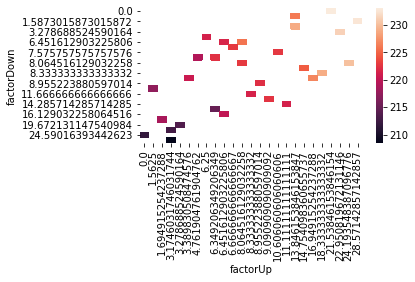

In [9]:
x_col = "factorDown"
y_col = "factorUp"
z_col = "mean"

# fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
sub_df = stats_df.loc[:, [x_col, y_col, z_col]]
# sub_df.drop_duplicates(subset=x_col, inplace=True)
# sub_df.drop_duplicates(subset=y_col, inplace=True)
pivoted = sub_df.pivot(x_col, y_col, z_col)

ax = sns.heatmap(pivoted)


plt.tight_layout()
plt.show()



## Training model

In [10]:
merged = pd.merge(left=df, right=stats_df, how='inner',
                 left_on='HomeTeam', right_on='team')

merged = pd.merge(left=merged, right=stats_df, how='inner',
                 left_on='AwayTeam', right_on='team')

X = merged.iloc[:, np.r_[6:13, 14:21]]

X = X.iloc[:, [0,1,2   ,7,8,9]]
X.head()

,mean_x,P25_x,P75_x,mean_y,P25_y,P75_y
0,222.933333,214.75,232.25,222.80303,211.25,234.75
1,219.317460,208.50,228.00,222.80303,211.25,234.75
2,222.651515,212.25,234.75,222.80303,211.25,234.75
3,225.870968,214.00,238.00,222.80303,211.25,234.75
4,214.984127,201.00,224.50,222.80303,211.25,234.75


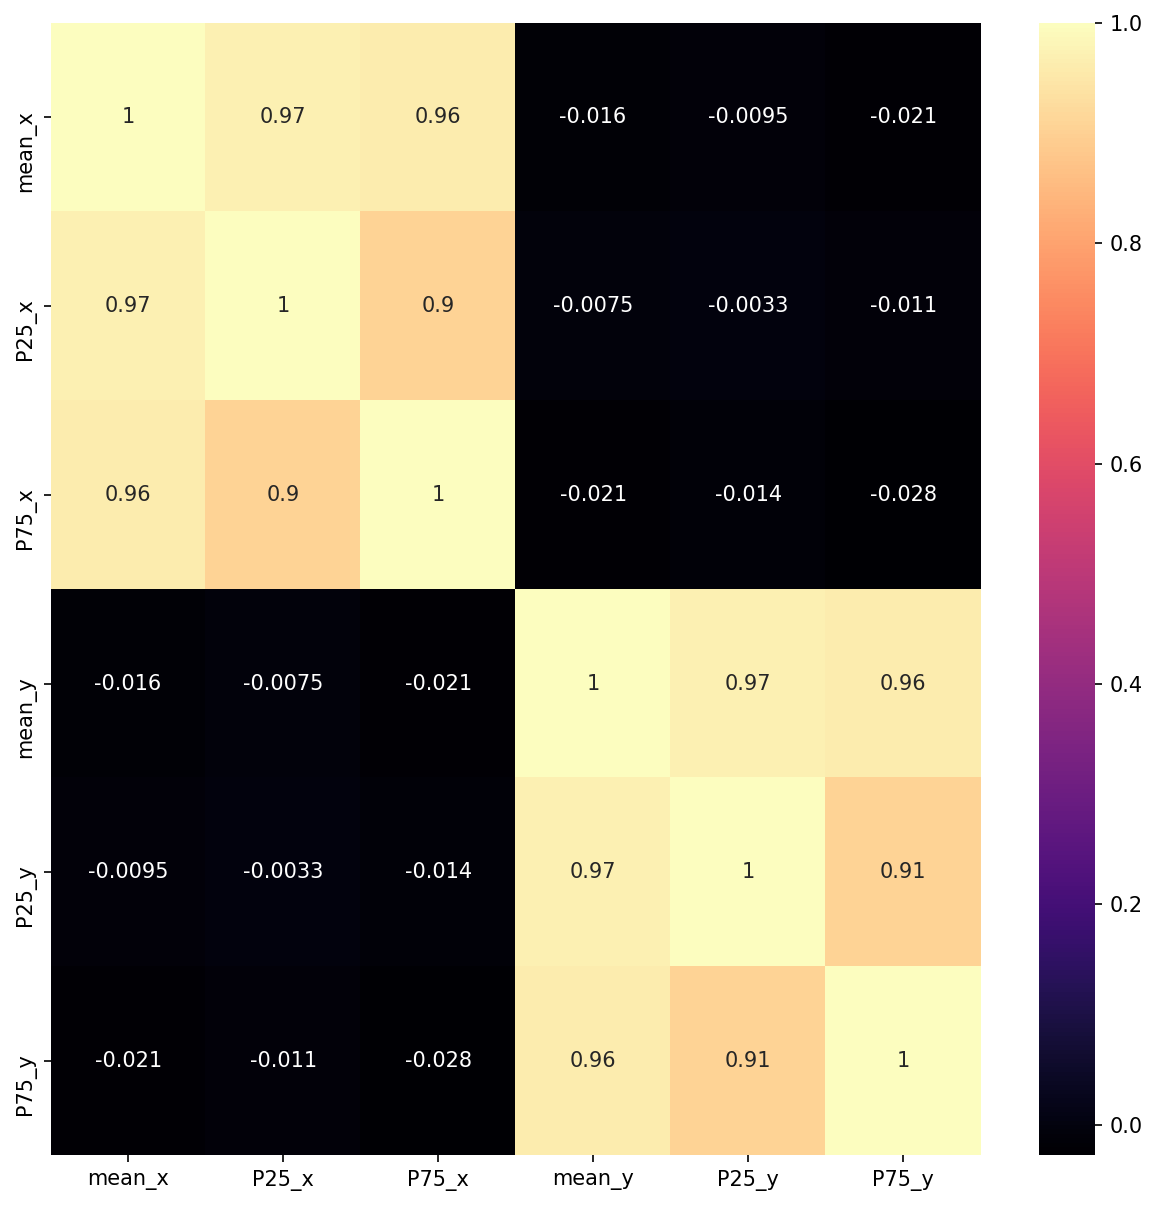

In [11]:
f_size = 10
plt.figure(figsize=(f_size,f_size), dpi=150)
sns.heatmap(X.corr(), annot = True, cmap = 'magma')
plt.show()

In [12]:
y = df['TotalScore'].values
y = y.astype(np.float64)
y = y.reshape(-1, 1)

In [13]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler, normalize
# fit scaler on training data
x_scaler = MinMaxScaler().fit(X)
# transform training data
X_norm = x_scaler.transform(X)

y_scaler = MinMaxScaler().fit(y)
y_norm = y_scaler.transform(y)


In [14]:
# Create training and validations sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.3, random_state=42)

In [15]:
# Create you neural net
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(9, input_dim=6, activation='sigmoid')) # 14
# model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# Train model
model.fit(X_norm, y_norm, epochs=500, batch_size=50, shuffle=True, verbose=2)

Epoch 1/500
19/19 - 1s - loss: 6.8004 - accuracy: 0.0011
Epoch 2/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 3/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 4/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 5/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 6/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 7/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 8/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 9/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 10/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 11/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 12/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 13/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 14/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 15/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 16/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 17/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 18/500
19/19 - 0s

Epoch 142/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 143/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 144/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 145/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 146/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 147/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 148/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 149/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 150/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 151/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 152/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 153/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 154/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 155/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 156/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 157/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 158/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.00

Epoch 281/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 282/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 283/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 284/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 285/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 286/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 287/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 288/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 289/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 290/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 291/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 292/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 293/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 294/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 295/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 296/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 297/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.00

Epoch 420/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 421/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 422/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 423/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 424/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 425/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 426/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 427/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 428/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 429/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 430/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 431/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 432/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 433/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 434/500
19/19 - 0s - loss: 6.8004 - accuracy: 0.0011
Epoch 435/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.0011
Epoch 436/500
19/19 - 0s - loss: 6.8003 - accuracy: 0.00

In [ ]:
# Evaluate model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

In [18]:
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_deno = y_scaler.inverse_transform(y_test)

data = np.concatenate((y_test_deno, predictions), axis=1)

# comparation = pd.DataFrame({'TrainSet': y_train_deno[:5], 'Prediction': predictions[:5]})
comparation = pd.DataFrame(data=data, columns=["Train", "Prediction"])
comparation['Prediction'] = comparation['Prediction'].round()
comparation['Error'] = abs(comparation['Train'] - comparation['Prediction'])
comparation = comparation.astype('int32')

print('The maximum error:', comparation['Error'].max())
print('The average error:', comparation['Error'].mean())
print('The dispersion of data:', comparation['Error'].std())

print('Max value of training set:', y_test_deno.max(), 'Min value of training set:', y_test_deno.min())
print('Max value of prediction set:', predictions.max(), 'Min value of prediction set:', predictions.min())

comparation.head(30)

The maximum error: 114
The average error: 57.734042553191486
The dispersion of data: 18.656575381133578
Max value of training set: 279.0 Min value of training set: 174.0
Max value of prediction set: 165.0 Min value of prediction set: 165.0


,Train,Prediction,Error
0,209,165,44
1,232,165,67
2,211,165,46
3,195,165,30
4,232,165,67
5,213,165,48
6,238,165,73
7,224,165,59
8,239,165,74
9,205,165,40


## Manually studying data

In [ ]:
conversion_dict = {
    'ATL': 'Atlanta Hawks',
    'BOS': 'Boston Celtics',
    'BKN': 'Brooklyn Nets',
    'CHA': 'Charlotte Hornets',
    'CHI': 'Chicago Bulls',
    'CLE': 'Cleveland Cavaliers',
    'DAL': 'Dallas Mavericks',
    'DEN': 'Denver Nuggets',
    'DET': 'Detroit Pistons',
    'GS': 'Golden State Warriors',
    'HOU': 'Houston Rockets',
    'IND': 'Indiana Pacers',
    'LAC': 'Los Angeles Clippers',
    'LAL': 'Los Angeles Lakers',
    'MEM': 'Memphis Grizzlies',
    'MIA': 'Miami Heat',
    'MIL': 'Milwaukee Bucks',
    'MIN': 'Minnesota Timberwolves',
    'NO': 'New Orleans Pelicans',
    'NY': 'New York Knicks',
    'OKC': 'Oklahoma City Thunder',
    'ORL': 'Orlando Magic',
    'PHX': 'Phoenix Suns',
    'PHI': 'Philadelphia 76ers',
    'POR': 'Portland Trail Blazers',
    'SAC': 'Sacramento Kings',
    'SA': 'San Antonio Spurs',
    'TOR': 'Toronto Raptors',
    'UTA': 'Utah Jazz',
    'WAS': 'Washington Wizards'
}

In [ ]:
future_games = [
    ['ATL', 'CHA'],
    ['BOS', 'DEN'],
    ['MIL', 'ORL'],
    ['NO', 'CLE'],
    ['CHI', 'MIN'],
    ['IND', 'MEM'],
    ['SA', 'DAL'],
    ['TOR', 'NY'],
    ['DET', 'LAC'],
    ['MIA', 'POR'],    
]

games_converted = list()
               
for game in future_games:
    home_team = conversion_dict[game[0]]
    away_team = conversion_dict[game[1]]
    game_ = [home_team, away_team]
    games_converted.append(game_)
    
for game in games_converted:
    df_ = stats_df.query("team == '{0}' or team == '{1}'".format(game[0], game[1]))
#     print(df_)
#     print(df_.iloc[:,[0,1,4,5]])
#     print("\n\n")
        